In [18]:
import tensorflow as tf
import numpy as np
import joblib
import os.path
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import scipy
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imported the neccessary libraries.

Load the resnet model from keras

In [19]:
resnet_50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

#initializes a pre-trained ResNet50 model from the Keras library, which has been trained on the ImageNet dataset, 
# with the option to exclude the fully connected layer at the top and specify the input shape.

In [20]:
train_path = 'model_data/train/axial'
valid_path = 'model_data/valid/axial'

In [21]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN', 'MCI'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN', 'MCI'], shuffle=False)
    
    ### Used the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

Found 1350 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [22]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    

In [23]:
imgs, labels = next(train_batches)

Currently the trainable parameters are: 23,534,592 which is not required for our current task.

In [24]:
resnet_50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

We can see that the model is a Functional API model.

In [25]:
type(resnet_50_model)

keras.engine.functional.Functional

We flatten the input to the model and then pass it to the output layer, which is a new Dense Layer with a two neurons. The output layer is the final layer of the model.

In [26]:
# Flatten output layer of Resnet
flattened = tf.keras.layers.Flatten()(resnet_50_model.output)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(3, activation='sigmoid', name="AddedDense1")(flattened)

model = tf.keras.models.Model(inputs=resnet_50_model.input, outputs=fc2)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot_resnet_multi.png', show_shapes=True, show_layer_names=True)

#print the architecture 

Apart from the 'AddedDense1' Layer that we created, all the rest of the layers are frozen.

In [30]:
for layer in model.layers:
    if layer.name == 'AddedDense1':
        break
    layer.trainable = False

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [32]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Adam optimizer with a learning rate of 0.0001, categorical cross-entropy loss function, and accuracy metric to be monitored.

In [33]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.1
    return lr

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

if os.path.isfile('models/adni_resnet_multi.h5'):
    model = load_model('models/adni_resnet_multi.h5')
    history = joblib.load('models/history/adni_resnet_multi.pkl')
else:
    history = model.fit(x=train_batches, steps_per_epoch=train_batches.n//train_batches.batch_size, validation_data=valid_batches, validation_steps=valid_batches.n//valid_batches.batch_size, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/adni_resnet_multi.pkl')
    
    model.save('models/adni_resnet_multi.h5')
    
    # defines a learning rate schedule that reduces the learning rate after a certain number of epochs. 
    # Also uses an early stopping callback to stop the training if the validation loss doesn't improve for a certain number of epochs. 
    # If a pre-trained model exists, it loads the weights and history, otherwise, it trains the model and saves the model and history to files.

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-03-13 01:22:58     98428016
metadata.json                                  2023-03-13 01:22:58           64
config.json                                    2023-03-13 01:22:58        85783
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_18
.........vars
......activation_19
.........vars
......activation_2
.........vars
......activation_20
.........vars
......activation_21
.........vars
......activation_22
.........vars
......activation_23
.........vars
..

# Tracking Convergence

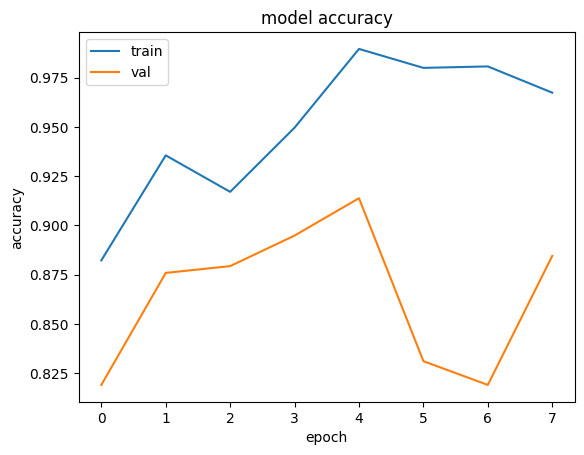

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plots model accuracy for training and validation data over epochs to visualize performance and detect overfitting/underfitting.


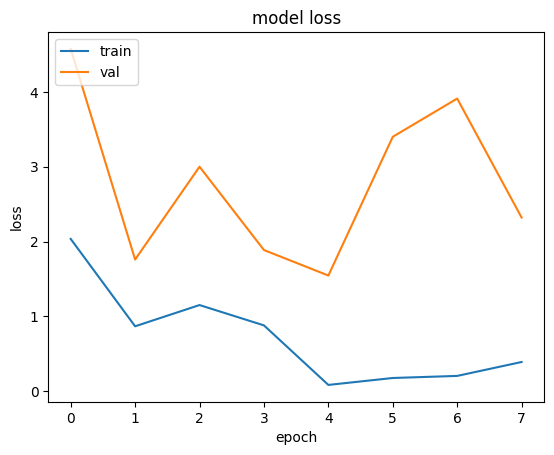

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plots the training and validation loss of a machine learning model over epochs to visualize overfitting or underfitting.


In [36]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    #plots a set of images in a grid format.

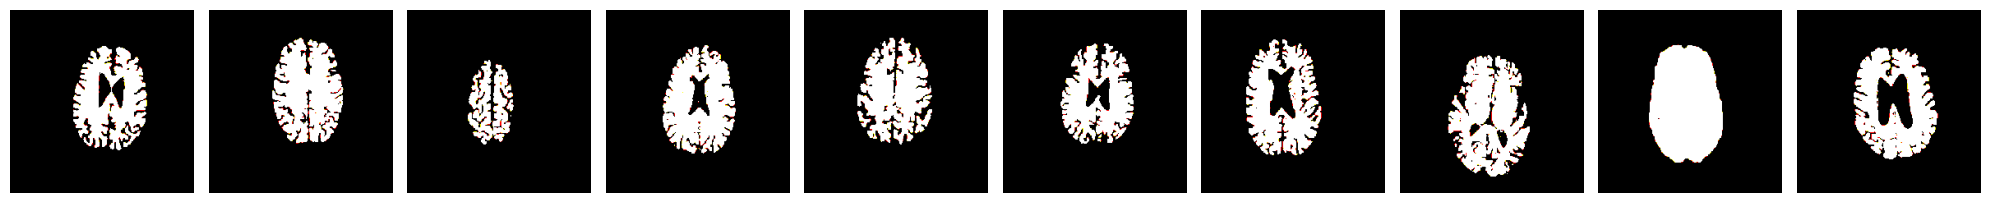

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [37]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels)

In [38]:
predictions = model.predict(x=valid_batches, verbose=0)

# generates predictions for a set of data called valid_batches and saves the predictions in a variable named 'predictions' for future evaluation.

In [39]:
np.round(predictions)

array([[1., 0., 1.],
       [1., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 1.],
       [0., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [40]:
test_imgs, test_labels = next(valid_batches)

In [41]:
test_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [42]:
import os
from tensorflow.keras.preprocessing.image import load_img

# Get the list of file names in the directory
file_names_ad = os.listdir(train_path + "/AD")

# Select the first file name from the list
first_file_name = file_names_ad[0]

# Load the first image
ad = load_img(train_path + "/AD/" + first_file_name)

# Get the list of file names in the directory
file_names_cn = os.listdir(train_path + "/CN")

# Select the first file name from the list
first_file_name = file_names_cn[0]

# Load the first image
cn = load_img(train_path + "/CN/" + first_file_name)

file_names_ad = os.listdir(train_path + "/MCI")

first_file_name = file_names_ad[0]

mci = ad = load_img(train_path + "/MCI/" + first_file_name)



In [43]:
# Preprocess the images using VGG16 preprocessing function
ad_processed = tf.keras.applications.vgg16.preprocess_input(np.array(ad.resize((224, 224))))
cn_processed = tf.keras.applications.vgg16.preprocess_input(np.array(cn.resize((224, 224))))
mci_processed = tf.keras.applications.vgg16.preprocess_input(np.array(mci.resize((224, 224))))

# Create a batch of size 2 with the processed images
visualize_batch = np.stack([ad_processed, cn_processed, mci_processed])


In [44]:
visualize_batch[0].shape

(224, 224, 3)

In [45]:
len(model.layers)

177

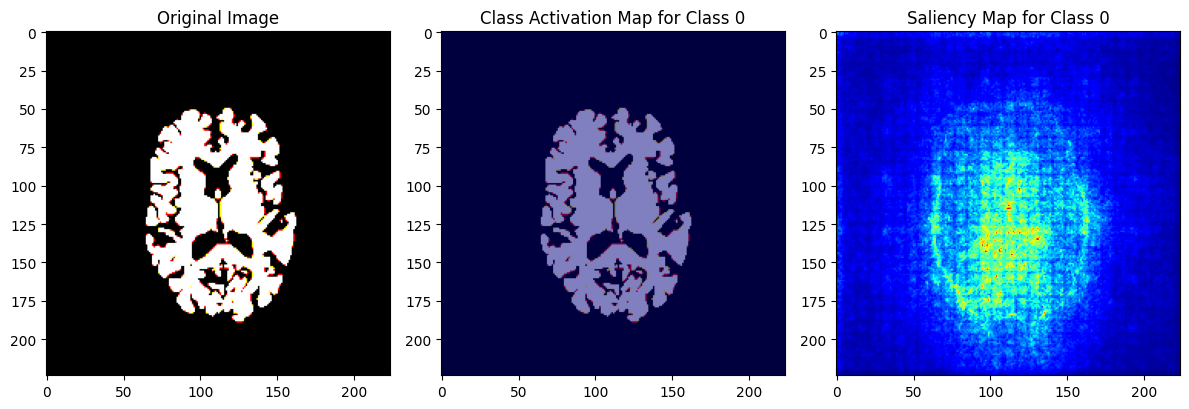

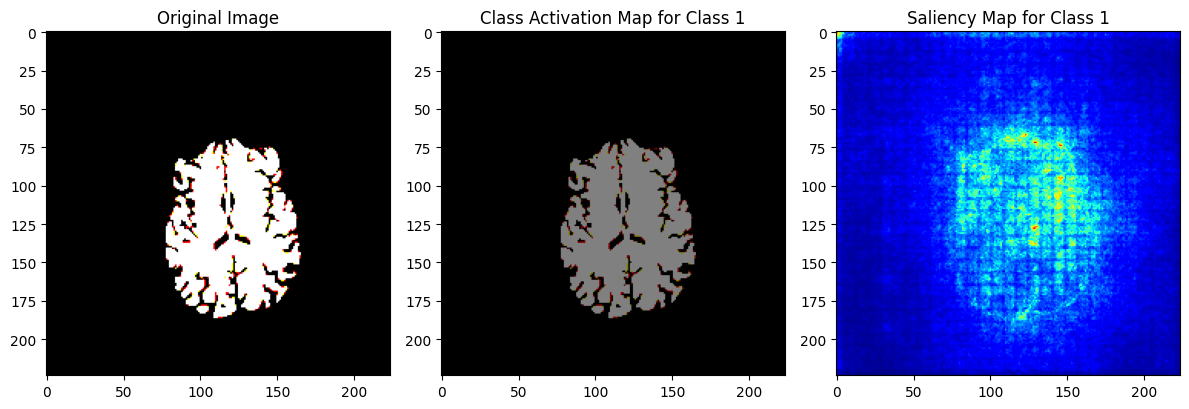

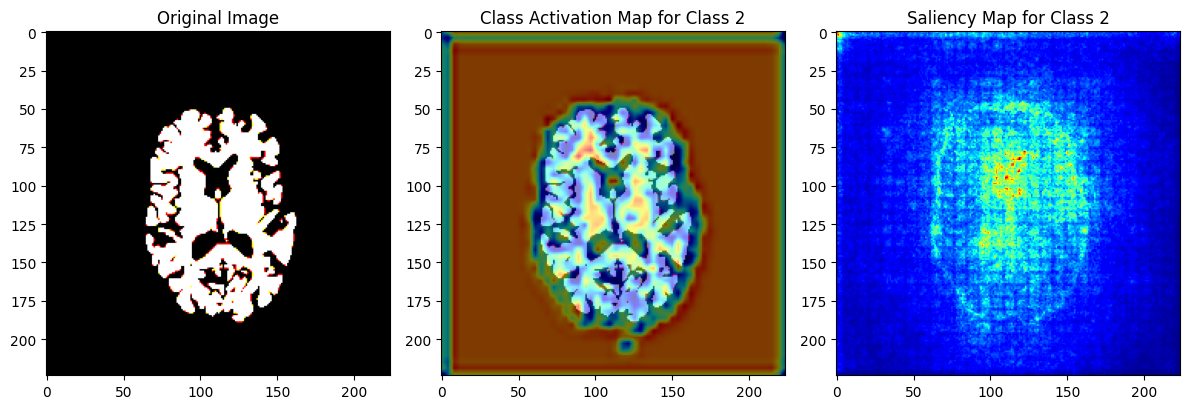

In [48]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
replace2linear = ReplaceToLinear() 



batch = valid_batches
# gradcam_model = tf.keras.models.Model(
#     [model.inputs], [model.layers[-3].output, model.output]
# )
# Create GradCAM++ object
# Create Gradcam object
gradcam = GradcamPlusPlus(model,
                  model_modifier=replace2linear,
                  clone=True)
# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map


# Loop over all classes and generate corresponding heatmaps
for class_index in range(len(valid_batches.class_indices)):
    # error = True
    # image_index = np.where(visualize_batch.classes == class_index)[0][0]
    image = visualize_batch[class_index]
    mapping = {
        0: 15,
        1: 20,
        2: 30
    }
    # Generate cam with GradCAM++
    cam = gradcam(CategoricalScore(class_index), image, penultimate_layer=mapping[class_index])
    saliency_map = saliency(CategoricalScore(class_index), image, smooth_samples=20, smooth_noise=0.20) # noise spread level.)
    
    # Plot the original image and the heatmap
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    axs[1].imshow(image)
    axs[1].imshow(heatmap, alpha=0.5, cmap='jet')
    axs[1].set_title(f'Class Activation Map for Class {class_index}')
    
    axs[2].imshow(saliency_map[0], cmap='jet')
    axs[2].set_title(f'Saliency Map for Class {class_index}')
    plt.tight_layout()
    plt.show()
    
    #the first subplot shows the original image, the second subplot overlays the image with a heatmap representing the class activation map for a specific class, 
    # and the third subplot shows the saliency map for the same class


In [74]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [75]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
 
    #This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #generates and displays a confusion matrix, which visualizes the performance of a classification model by showing
    # the number of correct and incorrect predictions for each class.
    

In [76]:
valid_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.856      0.064      0.08      ]
 [0.02873563 0.96551724 0.00574713]
 [0.00711744 0.15302491 0.83985765]]


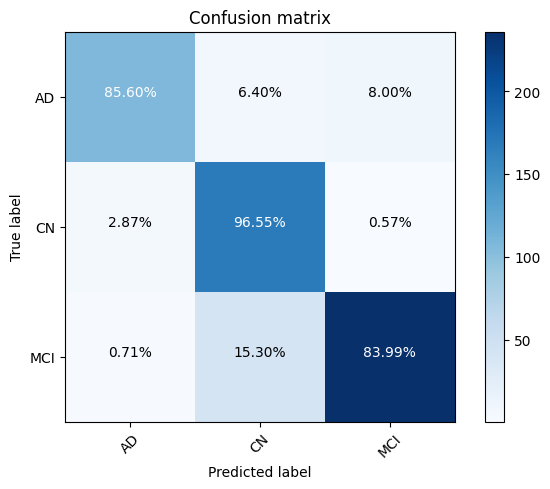

In [77]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize=True)

#Plotting the confusion matrix for multi-classifier to evaluate the accuracy for all three classes. 

In [78]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

###generating a report which includes various metrics such as precision, recall, f1-score, and support for each class. 

              precision    recall  f1-score   support

          AD       0.94      0.86      0.90       125
          CN       0.77      0.97      0.85       174
         MCI       0.96      0.84      0.89       281

    accuracy                           0.88       580
   macro avg       0.89      0.89      0.88       580
weighted avg       0.90      0.88      0.88       580

